I have divided the notebook in the following parts:
1. Getting Data and :
    * Preparing the Data
    * Visualizing the Data
2. Deep Neural Network
    * Training the Baseline
    * Optimizing the Baseline
3. Convolutional Neural Network
    * Training the Baseline CNN
    * Optimizing the CNN
4. Comparing Models and Selecting the Best

### Preparing Data

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [4]:
train_dataset = tf.data.TextLineDataset('data/sign_mnist_train.csv').skip(1)
test_dataset = tf.data.TextLineDataset('data/sign_mnist_test.csv').skip(1)

In [5]:
def parse_csv(line):
    split_line = tf.strings.split(line, ',')
    split_line = tf.strings.to_number(split_line)
    label = tf.reshape(split_line[0], [1])
    pixels = tf.reshape(split_line[1:], [32, 32])   # Since the dataset consists of 1024 features and a label.
    pixels = pixels/255
    
    return (pixels, label)

def preprocess(dataset, is_training_split=True, batch_size=32):
    dataset = dataset.map(parse_csv)

    splits = []
    if not is_training_split:
        leng = sum([1 for _ in dataset])
        split_leng = leng // 2
        valid_set = dataset.take(split_leng)
        test_set = dataset.skip(split_leng)
        splits.extend([valid_set, test_set])
    else:
        splits.append(dataset)

    processed_splits = []
    for split in splits:
        processed_split = split.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        processed_splits.append(processed_split)

    return processed_splits

In [6]:
[train_dataset] = preprocess(train_dataset)
[valid_dataset, test_dataset] = preprocess(test_dataset, is_training_split=False)

2024-08-13 18:48:24.613874: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
def find_unique_labels(dataset):
    unique_labels = set()
    
    for _, label in dataset: 
        label_value = label.numpy().flatten()[0]  
        unique_labels.add(label_value)  

    return sorted(unique_labels)

unique_labels = find_unique_labels(train_dataset)
print("Unique labels:", unique_labels)
print('Total Unique Labels: ', len(unique_labels))

Unique labels: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0]
Total Unique Labels:  24


2024-08-13 18:48:24.894436: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Surprisingly, there are only 24 letters labels while the actal ASL contains 26. After a little research, I found out that the letters 'J' and 'Z' are not used in many datasets because of the way they are used. So is the case with our dataset. <br>
Now, we can not use 24 neurons in the output layer, because in that case the maximum value of labels would be 23 (0 to 23), while the maximum label value here is 24, causing a mismatch. Moreover, we can't just remap the labels either, because that would mess with their character representations while using `ord`.<br>
Thus, I am resorting to using 25 neurons in the final layer instead of 24 - this solves both of the problems above but might lead to _slightly_ less accurate results.

#### Visualizations

/tmp/ipykernel_90565/1690095945.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_value = int(labels[j].numpy())


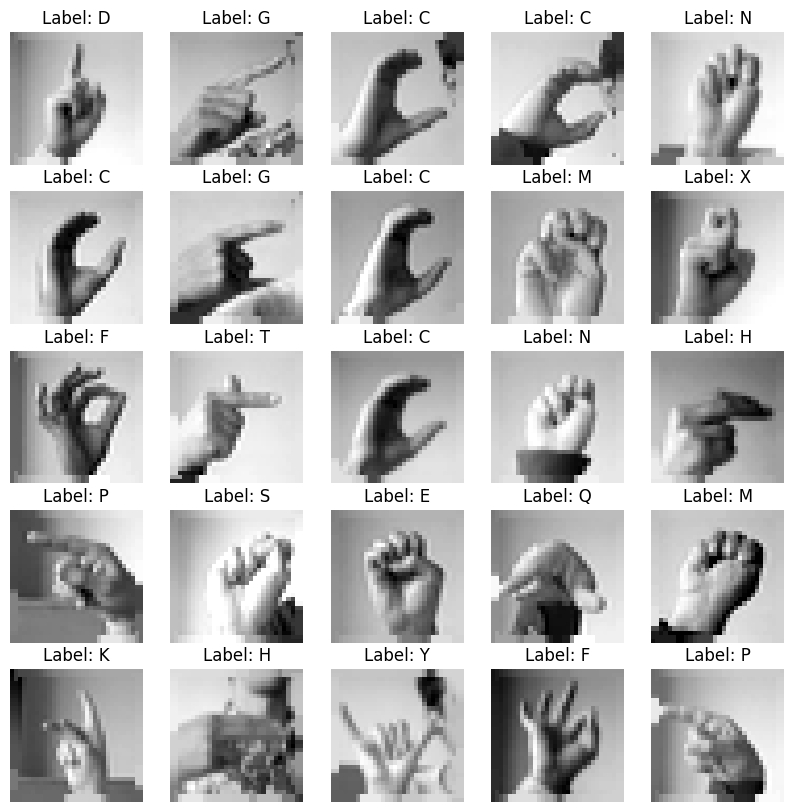

In [8]:
def display_sample_images(dataset, num_samples=5):
    plt.figure(figsize=(10, 10))
    for i, (images, labels) in enumerate(dataset.take(num_samples)):
        for j in range(num_samples):
            ax = plt.subplot(num_samples, num_samples, i * num_samples + j + 1)
            plt.imshow(images[j].numpy(), cmap='gray')
            
            label_value = int(labels[j].numpy())
            label_char = chr(label_value + ord('A'))  
            
            plt.title(f"Label: {label_char}")
            plt.axis('off')
    plt.show()

display_sample_images(train_dataset)

#### Baseline Model Training

In [7]:
baseline_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32)),  
    keras.layers.Dense(256, activation='relu'),  
    keras.layers.Dense(128, activation='relu'),  
    keras.layers.Dense(25, activation='softmax')  
])

baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 25)                3225      
                                                                 
Total params: 298521 (1.14 MB)
Trainable params: 298521 (1.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping = keras.callbacks.EarlyStopping(patience=10)


callbacks=[early_stopping, tensorboard]
baseline_model.compile(optimizer=keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
baseline_model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=100,  
    verbose=1,
    callbacks=callbacks
)

Epoch 1/100


I0000 00:00:1723571913.345998   14968 service.cc:146] XLA service 0x712cdc6c7f30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723571913.346025   14968 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2024-08-13 13:58:33.351308: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-13 13:58:33.359918: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-08-13 13:58:33.368707: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibil

    827/Unknown - 1s 918us/step - loss: 2.0549 - accuracy: 0.3646

2024-08-13 13:58:34.366765: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-13 13:58:34.513381: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12010131797079615663
2024-08-13 13:58:34.513413: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11511297893087389714
2024-08-13 13:58:34.513424: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4175100409000529342


858/858 [==============================] - 2s 1ms/step - loss: 2.0292 - accuracy: 0.3717 - val_loss: 1.6726 - val_accuracy: 0.4529
Epoch 2/100
858/858 [==============================] - 1s 1ms/step - loss: 1.0628 - accuracy: 0.6577 - val_loss: 1.3876 - val_accuracy: 0.5399
Epoch 3/100
858/858 [==============================] - 1s 1ms/step - loss: 0.6661 - accuracy: 0.7847 - val_loss: 1.2238 - val_accuracy: 0.6009
Epoch 4/100
858/858 [==============================] - 1s 1ms/step - loss: 0.4344 - accuracy: 0.8617 - val_loss: 1.0623 - val_accuracy: 0.6645
Epoch 5/100
858/858 [==============================] - 1s 1ms/step - loss: 0.2782 - accuracy: 0.9139 - val_loss: 0.9925 - val_accuracy: 0.7125
Epoch 6/100
858/858 [==============================] - 1s 1ms/step - loss: 0.1927 - accuracy: 0.9433 - val_loss: 0.9859 - val_accuracy: 0.7387
Epoch 7/100
858/858 [==============================] - 1s 1ms/step - loss: 0.1162 - accuracy: 0.9692 - val_loss: 1.0688 - val_accuracy: 0.7482
Epoch 8/100

#### Learning Curves using TensorBoard

In [9]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 4782), started 0:08:28 ago. (Use '!kill 4782' to kill it.)

### Optimizing the Dense Nets

In [12]:
l1_regularizer = keras.regularizers.l1(0.001)

model_2 = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32)),  
    keras.layers.Dense(256, activation='relu', kernel_regularizer=l1_regularizer),  
    keras.layers.Dense(128, activation='relu', kernel_regularizer=l1_regularizer),  
    keras.layers.Dense(25, activation='softmax')  
])

model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 25)                3225      
                                                                 
Total params: 298521 (1.14 MB)
Trainable params: 298521 (1.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
callbacks_2 = callbacks.copy()
adam = keras.optimizers.Adam(learning_rate=0.0008)
model_2.compile(optimizer=keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_2.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=100,  
    verbose=1,
    callbacks=callbacks_2
)

In [9]:
# class OneCycleScheduler(tf.keras.callbacks.Callback):
#     def __init__(self, max_lr, total_steps, start_lr=None, last_lr=None):
#         super(OneCycleScheduler, self).__init__()
#         self.max_lr = max_lr
#         self.total_steps = total_steps
#         self.start_lr = start_lr or max_lr / 10
#         self.last_lr = last_lr or self.start_lr / 100
#         self.step = 0
        
#     def on_train_begin(self, logs=None):
#         # Initial learning rate
#         tf.keras.backend.set_value(self.model.optimizer.lr, self.start_lr)
    
#     def on_batch_end(self, batch, logs=None):
#         # Learning rate for the current step
#         self.step += 1
#         lr = self.calculate_lr()
#         tf.keras.backend.set_value(self.model.optimizer.lr, lr)
    
#     def calculate_lr(self):
#         # Phase 1: Increase learning rate
#         if self.step < self.total_steps // 2:
#             return self.start_lr + (self.max_lr - self.start_lr) * self.step / (self.total_steps // 2)
#         # Phase 2: Decrease learning rate
#         else:
#             return self.max_lr - (self.max_lr - self.last_lr) * (self.step - self.total_steps // 2) / (self.total_steps // 2)
    
#     def on_train_end(self, logs=None):
        # tf.keras.backend.set_value(self.model.optimizer.lr, self.start_lr)


In [34]:
l1_regularizer = keras.regularizers.l1(0.0005)

model_3 = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32)),  
    keras.layers.Dense(300, activation='relu', kernel_regularizer=l1_regularizer),  
    keras.layers.Dense(300, activation='relu', kernel_regularizer=l1_regularizer),  
    keras.layers.Dense(25, activation='softmax')  
])

model_3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 1024)              0         
                                                                 
 dense_33 (Dense)            (None, 300)               307500    
                                                                 
 dense_34 (Dense)            (None, 300)               90300     
                                                                 
 dense_35 (Dense)            (None, 25)                7525      
                                                                 
Total params: 405325 (1.55 MB)
Trainable params: 405325 (1.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)
adam_2 = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model_3.compile(optimizer=adam_2, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_3.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=100,
    callbacks=callbacks_2
)

Looking at our learning curves above, L1 Regularized model isn't performing any better than our unregularized model. The extent of overfitting is still huge, and we need to resort to other regularization techniques like **Dropout**. I initially planned to use **Batch Normalization** to speed up the training as well, but it introduced a large number additional parameters so I didn't train that one. Apart from that, I have tried various *Learning Rate schedules** including **OneCycle, Power Scheduling, and Exponential Scehduling**

In [24]:
model_4 = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32)),
    keras.layers.Dense(390, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(200, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(25, activation='softmax')
])

model_4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 390)               399750    
                                                                 
 dropout_2 (Dropout)         (None, 390)               0         
                                                                 
 dense_3 (Dense)             (None, 200)               78200     
                                                                 
 dropout_3 (Dropout)         (None, 200)               0         
                                                                 
 dense_4 (Dense)             (None, 25)                5025      
                                                                 
Total params: 482975 (1.84 MB)
Trainable params: 48297

In [25]:
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=0.001,
#     decay_steps=6000,
#     decay_rate=0.95,
#     staircase=True)

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.5,  
    staircase=False  
)

adam_3 = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model_4.compile(optimizer=adam_3, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_4.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=100,
    callbacks=callbacks_2
)

Epoch 1/100
858/858 [==============================] - 1s 1ms/step - loss: 2.0556 - accuracy: 0.3528 - val_loss: 1.6506 - val_accuracy: 0.4635
Epoch 2/100
  1/858 [..............................] - ETA: 2s - loss: 1.5643 - accuracy: 0.3750

2024-08-13 18:56:29.440099: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-13 18:56:29.440130: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12928548483665287324
2024-08-13 18:56:29.440147: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2002489744867085825
2024-08-13 18:56:29.586499: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10153783695264448994
2024-08-13 18:56:29.586519: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9797899111602208726


858/858 [==============================] - 1s 1ms/step - loss: 1.1345 - accuracy: 0.6149 - val_loss: 1.2252 - val_accuracy: 0.5825
Epoch 3/100
858/858 [==============================] - 1s 1ms/step - loss: 0.7568 - accuracy: 0.7419 - val_loss: 1.0624 - val_accuracy: 0.6573
Epoch 4/100
858/858 [==============================] - 1s 1ms/step - loss: 0.5624 - accuracy: 0.8067 - val_loss: 0.8735 - val_accuracy: 0.7044
Epoch 5/100
858/858 [==============================] - 1s 1ms/step - loss: 0.4416 - accuracy: 0.8488 - val_loss: 0.9304 - val_accuracy: 0.7041
Epoch 6/100
858/858 [==============================] - 1s 1ms/step - loss: 0.3511 - accuracy: 0.8793 - val_loss: 0.8321 - val_accuracy: 0.7362
Epoch 7/100
858/858 [==============================] - 1s 1ms/step - loss: 0.2879 - accuracy: 0.9018 - val_loss: 0.8875 - val_accuracy: 0.7535
Epoch 8/100
858/858 [==============================] - 1s 1ms/step - loss: 0.2487 - accuracy: 0.9149 - val_loss: 0.9026 - val_accuracy: 0.7351
Epoch 9/100

In [22]:
import numpy as np
from sklearn.metrics import accuracy_score
from collections import Counter

def evaluate_model_performance(model, dataset):
    # Prepare lists to store true labels and predictions
    true_labels = []
    predictions = []

    # Iterate over the dataset to get predictions
    for batch in dataset:
        images, labels = batch
        preds = model.predict(images)
        preds = np.argmax(preds, axis=1)  # Convert predictions to class labels
        
        true_labels.extend(labels.numpy().flatten())  # Flatten to ensure it's 1D
        predictions.extend(preds.flatten())  # Flatten to ensure it's 1D

    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Calculate individual accuracies for each letter
    unique_labels = np.unique(true_labels)
    individual_accuracies = {}
    
    for label in unique_labels:
        label_mask = (true_labels == label)
        accuracy = accuracy_score(true_labels[label_mask], predictions[label_mask])
        individual_accuracies[chr(int(label) + ord('A'))] = accuracy
    
    # Overall mean accuracy
    overall_mean_accuracy = accuracy_score(true_labels, predictions)
    
    # Unbiased median accuracy
    median_accuracy = np.median(list(individual_accuracies.values()))
    
    # Highest and lowest individual accuracy
    highest_accuracy = max(individual_accuracies.values())
    lowest_accuracy = min(individual_accuracies.values())
    
    highest_accuracy_letter = max(individual_accuracies, key=individual_accuracies.get)
    lowest_accuracy_letter = min(individual_accuracies, key=individual_accuracies.get)
    
    # Identify the three most common single types of errors
    errors = [(true, pred) for true, pred in zip(true_labels, predictions) if true != pred]
    common_errors = Counter(errors).most_common(3)
    
    # Convert numeric labels to letters for errors
    common_errors_letters = [
        (chr(int(true_label) + ord('A')), chr(int(pred_label) + ord('A')), count)
        for (true_label, pred_label), count in common_errors
    ]
    
    return {
        "overall_mean_accuracy": overall_mean_accuracy,
        "median_accuracy": median_accuracy,
        "highest_accuracy": highest_accuracy,
        "highest_accuracy_letter": highest_accuracy_letter,
        "lowest_accuracy": lowest_accuracy,
        "lowest_accuracy_letter": lowest_accuracy_letter,
        "individual_accuracies": individual_accuracies,
        "common_errors": common_errors_letters
    }

In [ ]:
metrics_1 = evaluate_model_performance(model_4, valid_dataset)

In [27]:
metrics_1

{'overall_mean_accuracy': 0.8195761293920804,
 'median_accuracy': 0.846389806512506,
 'highest_accuracy': 1.0,
 'highest_accuracy_letter': 'A',
 'lowest_accuracy': 0.5,
 'lowest_accuracy_letter': 'V',
 'individual_accuracies': {'A': 1.0,
  'B': 0.9318181818181818,
  'C': 0.9935897435897436,
  'D': 0.9067796610169492,
  'E': 1.0,
  'F': 0.9274193548387096,
  'G': 0.8536585365853658,
  'H': 0.958904109589041,
  'I': 0.5970149253731343,
  'K': 0.7602339181286549,
  'L': 1.0,
  'M': 0.8461538461538461,
  'N': 0.5214285714285715,
  'O': 0.7244094488188977,
  'P': 1.0,
  'Q': 0.8395061728395061,
  'R': 0.5714285714285714,
  'S': 0.7314814814814815,
  'T': 0.696969696969697,
  'U': 0.5227272727272727,
  'V': 0.5,
  'W': 0.6,
  'X': 0.9407407407407408,
  'Y': 0.8466257668711656},
 'common_errors': [('V', 'W', 50), ('T', 'X', 25), ('U', 'K', 25)]}

### CNN

Since our models above with 200-300K parameters are overfitting, it is unreasonable to increase the number of parameters. However, reducing the number of parameters would lead to underfitting (check the table at the bottom). Plus, we are restricted by the 50-run requirements, so I shall try to use our knowledge from previous runs to get a CNN working within the first couple of tries.

In [10]:
model_5 = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    keras.layers.MaxPooling2D((3, 3)),
    keras.layers.Conv2D(64, (2, 2), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(26, activation='softmax')
])

model_5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 10, 10, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 10, 10, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          8256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 64)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 4, 64)          0

In [15]:
adam_4 = keras.optimizers.Adam(learning_rate=lr_schedule)   # Same Power Scheduler from previous run
model_5.compile(optimizer=adam_4,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
cnn_history = model_5.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=100,  
    verbose=1,
    callbacks=callbacks_2
)

#### Optimizing the CNN
That's a big improvement, an accuracy of 0.87! But it still overfits, as traininng set accuracy is 0.98. I'll play my final card, by introducing a 50% Dropout after each convolutional block.

In [ ]:
model_6 = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    keras.layers.MaxPooling2D((3, 3)),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(64, (2, 2), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(26, activation='softmax')
])

model_6.summary()

In [ ]:
metrics_2 = evaluate_model_performance(model_6, test_dataset)

In [40]:
metrics_2['individual_accuracies']

{'A': 1.0,
 'B': 1.0,
 'C': 1.0,
 'D': 1.0,
 'E': 1.0,
 'F': 1.0,
 'G': 0.9130434782608695,
 'H': 1.0,
 'I': 0.9545454545454546,
 'K': 0.96875,
 'L': 1.0,
 'M': 0.9296482412060302,
 'N': 0.9933774834437086,
 'O': 0.9243697478991597,
 'P': 1.0,
 'Q': 1.0,
 'R': 1.0,
 'S': 0.8695652173913043,
 'T': 0.7241379310344828,
 'U': 0.917910447761194,
 'V': 0.974025974025974,
 'W': 1.0,
 'X': 1.0,
 'Y': 0.9053254437869822}

In [37]:
for key, value in metrics_2.items():
    if not key == 'individual_accuracies':
        print(key, value)

overall_mean_accuracy 0.9629113218070273
median_accuracy 1.0
highest_accuracy 1.0
highest_accuracy_letter A
lowest_accuracy 0.7241379310344828
lowest_accuracy_letter T
common_errors [('T', 'H', 17), ('G', 'H', 16), ('S', 'E', 14)]


1/1 [==============================] - 0s 8ms/step


2024-08-13 19:14:11.844088: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


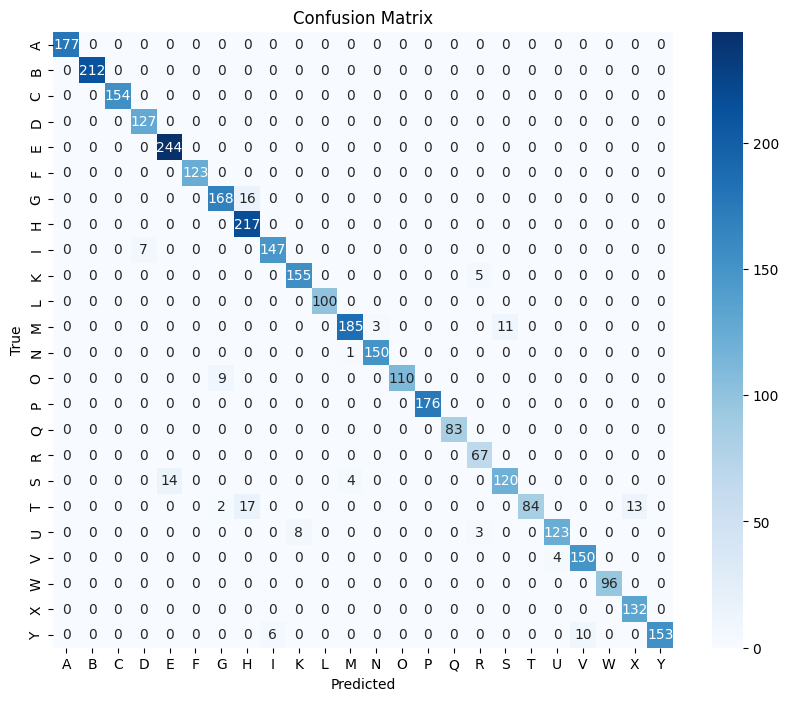

In [43]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, dataset, class_names):
    true_labels = []
    predictions = []

    for batch in dataset:
        images, labels = batch
        preds = model.predict(images)
        preds = np.argmax(preds, axis=1)  
        true_labels.extend(labels.numpy().flatten())
        predictions.extend(preds.flatten())

    # Filter out J (index 9) and Z (index 25) from the labels and predictions
    valid_indices = [i for i in range(len(true_labels)) if true_labels[i] != 9 and true_labels[i] != 25]
    true_labels = np.array(true_labels)[valid_indices]
    predictions = np.array(predictions)[valid_indices]

    # Adjust labels for confusion matrix plotting
    true_labels = [label - 1 if label > 9 else label for label in true_labels]
    predictions = [label - 1 if label > 9 else label for label in predictions]

    cm = confusion_matrix(true_labels, predictions)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

class_names = [chr(i) for i in range(ord('A'), ord('Z') + 1) if chr(i) not in ['J', 'Z']]
plot_confusion_matrix(model_5, test_dataset, class_names)

### Selection of Best Model

For the sake of cleanliness, I have cleared some ugly looking cell outputs (with irrelevant TensorFlow warning etc.). Here is a summary of all the training runs:<br>

| **Run** | **Model Architecture**                       | **Optimizer** |**Additional Info**| **Initial Learning Rate** | **Epochs** | **Best Validation Accuracy** |
|---------|----------------------------------------------|---------------|-----|--------------|------------|-----------------------------|
| 1       | Flatten() - Dense(256) - Dense(128) - Output() | Adam         | -- | 0.001             | 16         | 0.79                        |
| 2       | Flatten() - Dense(256) - Dense(238) - Output() | Adam         | -- | 0.001 (7 Epochs), then 0.0005 (7 Epochs)           | 14   | 0.79 |
| 3       | Flatten() - Dense(300) - Dense(120) - Output() | Adam         | L1 Regularization 0.001 + Exponential Scaling | 0.0005 (15 Epochs), then 0.00005 (7 Epochs)        | 22   | 0.69 |
| 4       | Conv2D(32) - MaxPooling2D(3x3)-Conv2D(64)-MaxPooling2D(2x2)-Conv2D(128)-Flatten()-Dense(64)-Output(26 softmax)| Adam        | Power Scheduling | 0.001        | 23   | 0.87 |
| 5       | Conv2D(32) - MaxPooling2D(3x3)-Conv2D(64)-MaxPooling2D(2x2)-Conv2D(128)-Flatten()-Dense(64)-Output(26 softmax)| Adam        | Power Scheduling + 50% Dropout| 0.001        | 23   | 0.96 |

<p style="text-align: right; font-size: smaller;">
  *All the results are completely reproducible. In case you want to verify, just re-run the cells.
</p>

**Recommendation** <br>
'T' is the only character with unsatisfactory individual accuracy. The overall scores of our CNN are phenomenal and production-ready. Also, it is clearly far superior than the first model (check test accuracies above). The errors on 'T' are minor and can be addressed post-deployment with continous monitoring or through retraining as new data arrives. Apart from this, all the requirements of client are satisfied. Here are some of the problems I faced and strategies I used to overcome those:
* The model architecture was quite restrictive and had to build one within the 500K limit, hence there was no scope of a third layer in the DNN. Although this wasn't a major hurdle as the dataset was quit small and probably didn't need a stronger model.
* Almost all the models except our CNN were overfitting. I tried L1 Regularization, because I know by experience, most of the information in usual MNIST datasets can be explained by a smaller subset of features, and hence L1 could do good feature selection. However, this hypothesis failed in our model 2. Finally, I resorted to Dropout, and it was quite promising in each model I used.

Here are two of the learning curves in case the TensorBoard doesn't render in your machine:

CNN: <br>
<img src="images/cnn_lc.png" alt="DNN Learning Curves" style="width: 600px;"/>

DNN: <br>
<img src="images/dnn_lc.png" alt="DNN Learning Curves" style="width: 600px;"/>

In [45]:
model_5.save('saved_models/model_5.keras')